In [36]:
import numpy as np 
import pandas as pd
import networkx as nx 
import torch
import matplotlib.pyplot as plt
from bisect import bisect_left
import random
from cdlib import algorithms
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from node2vec import Node2Vec

## Task 0 - Create Graphs

### Extract data from the txt files


In [4]:
path = "Cit-HepPh.txt"
path2 = "cit-HepPh-dates.txt"
data = []
with open(path, "r") as file:
    for line in file:
        values = line.strip().split()
        values[0]=int(values[0])
        values[1]=int(values[1])
        data.append(values)

data = sorted(data, key=lambda x: (x[0], x[1]))
print(len(data))
print(data[0:100])
# data is sorted

# ERROR->
check_array = np.zeros(len(data))
###########

date_published = {}
with open(path2, "r") as file:
    for line in file:
        values = line.strip().split()
        values[0]=int(values[0])
        date_published[values[0]]=values[1]

date_published = dict(sorted(date_published.items(), key=lambda item: (item[1][0:4], item[1][5:7], item[1][8:10])))
# date_published = dict(sorted(date_published.items(), key=lambda item: item[0]))
        
print(date_published)
print(len(date_published))
# date_published dictionary is sorted on the basis of the dates the papers are published


421578
[[1001, 9212308], [1001, 9305239], [1001, 9306240], [1001, 9312276], [1001, 9312333], [1001, 9401294], [1001, 9403226], [1001, 9409265], [1001, 9511336], [1001, 9601359], [1001, 9602280], [1001, 9610553], [1001, 9701390], [1001, 9702424], [1001, 9708239], [1001, 9709423], [1001, 9710255], [1001, 9802439], [1001, 9810389], [1001, 9810409], [1001, 9903515], [1001, 9903516], [1001, 9905323], [1001, 9907385], [1001, 9907523], [1001, 9908523], [1001, 9909506], [1001, 9910563], [1001, 9912251], [1002, 9303309], [1002, 9307201], [1002, 9401219], [1002, 9407389], [1002, 9409375], [1002, 9503443], [1002, 9504316], [1002, 9508343], [1002, 9606211], [1002, 9606386], [1002, 9609331], [1002, 9803277], [1002, 9807423], [1002, 9808299], [1002, 9808312], [1002, 9811308], [1002, 9812320], [1002, 9812472], [1002, 9902371], [1002, 9902443], [1002, 9903404], [1002, 9907422], [1002, 9909540], [1002, 9912236], [1002, 9912463], [1002, 9912516], [1003, 9311243], [1003, 9405410], [1003, 9503208], [1003,

### Creating graphs from extracted data
- We create an array of graphs in which the i<sup>th</sup> graph holds all the data about the citation network from 1992 till the year **1992 + i**
- This helps us analyze how the graph is changing over the years
  
**Method**  
We add papers as nodes to the graph on the basis of the date they were published.  
After adding a paper to the network, we draw all those edges which originate from that node to other nodes (the papers the current paper has cited)

In [5]:
# Create graph year by year
G = nx.DiGraph()

G_array = []
iterator = iter(date_published.items())

# def fn(arr):
#     for ele in arr:
#         print(ele.number_of_nodes(), end=" ")
#     print()
#     for ele in arr:
#         print(ele.number_of_edges(), end=" ")
#     print()

prev_year_and_month = "-1"
curr_year_and_month = "1992-02"
x_time = []

for node, date in iterator:
    # adds a graph instance to the graph array
    curr_year_and_month = date[0:7]
    if curr_year_and_month !=prev_year_and_month:
        if prev_year_and_month!="-1":
            x_time.append(curr_year_and_month)
            print(f"Current year and month = {curr_year_and_month}")
            print(f"previous year and month = {prev_year_and_month}")
            print(f"number of nodes in G = {G.number_of_nodes()}")
            print(f"Number of edges in G = {G.number_of_edges()}")
            G_array.append(G.copy())
            print(f"size of G_array = {len(G_array)}")
            print()
    prev_year_and_month = curr_year_and_month

    # creates the next graph instance
    G.add_node(node)
    ind = bisect_left(data, [node, float('-inf')])
    for i in range(ind, len(data)):
        if data[i][0] != node:
            break
        G.add_edges_from([data[i]])
        check_array[i]=1

x_time.append(curr_year_and_month)
print(f"Current year and month = {curr_year_and_month}")
print(f"previous year and month = {prev_year_and_month}")
print(f"number of nodes in G = {G.number_of_nodes()}")
print(f"Number of edges in G = {G.number_of_edges()}")
G_array.append(G.copy())
print(f"size of G_array = {len(G_array)}")
print()

Current year and month = 1992-03
previous year and month = 1992-02
number of nodes in G = 2
Number of edges in G = 0
size of G_array = 1

Current year and month = 1992-04
previous year and month = 1992-03
number of nodes in G = 31
Number of edges in G = 3
size of G_array = 2

Current year and month = 1992-05
previous year and month = 1992-04
number of nodes in G = 72
Number of edges in G = 4
size of G_array = 3

Current year and month = 1992-06
previous year and month = 1992-05
number of nodes in G = 125
Number of edges in G = 7
size of G_array = 4

Current year and month = 1992-07
previous year and month = 1992-06
number of nodes in G = 202
Number of edges in G = 12
size of G_array = 5

Current year and month = 1992-08
previous year and month = 1992-07
number of nodes in G = 292
Number of edges in G = 25
size of G_array = 6

Current year and month = 1992-09
previous year and month = 1992-08
number of nodes in G = 364
Number of edges in G = 32
size of G_array = 7

Current year and mont

### Note: Some datapoints have been excluded

In [14]:
count=0
cat1 = set()
cat2 = set()
for i , check_val in enumerate(check_array):
    if check_val == 0:
        cat1.add(data[i][0])
        cat2.add(data[i][1])
        count+=1
print(f"count = {count}")
print(cat1)
print(cat2)
print(len(cat1))
# THE NODES IN THE SET cat1 ARE NOT PRESENT IN THE DATES.TXT FILE
# THEY ARE ONLY PRESENT IN THE EDGES.TXT FILE
# SO, THESE PAPERS ARE NOT BEING ADDED TO OUR GRAPH, AND NEITHER ARE THE EDGES ORIGINATING FROM THESE PAPERS

count = 74164
{301222, 301223, 301224, 301225, 211336, 301226, 301227, 301228, 301229, 301230, 211337, 212314, 301231, 301233, 301234, 301235, 211338, 212315, 301236, 301237, 301238, 301239, 301240, 211339, 212316, 301241, 302122, 301242, 301243, 301244, 301245, 212317, 301246, 301247, 301248, 301249, 301250, 211341, 212318, 301252, 301253, 301254, 301255, 211342, 212319, 301256, 301257, 301258, 301260, 211343, 301261, 205001, 205003, 205004, 205005, 212320, 205007, 205008, 205009, 205010, 205011, 205012, 205013, 205014, 205015, 205016, 205017, 301263, 205019, 205020, 205021, 205022, 205023, 205024, 205025, 205026, 205027, 205028, 205029, 205030, 205031, 205032, 205033, 205034, 205035, 205036, 205037, 205038, 205039, 205040, 205041, 205042, 205043, 205044, 205045, 205046, 205047, 205048, 205049, 205050, 205051, 205052, 205053, 205054, 205055, 205056, 205057, 205058, 205059, 205060, 205061, 205062, 205063, 205064, 205065, 205066, 205067, 205068, 205069, 205070, 205071, 205072, 205073, 2

## Task 1 - Temporal Properties

### Property 1 - Plotting the number of papers and citations against time

122
122


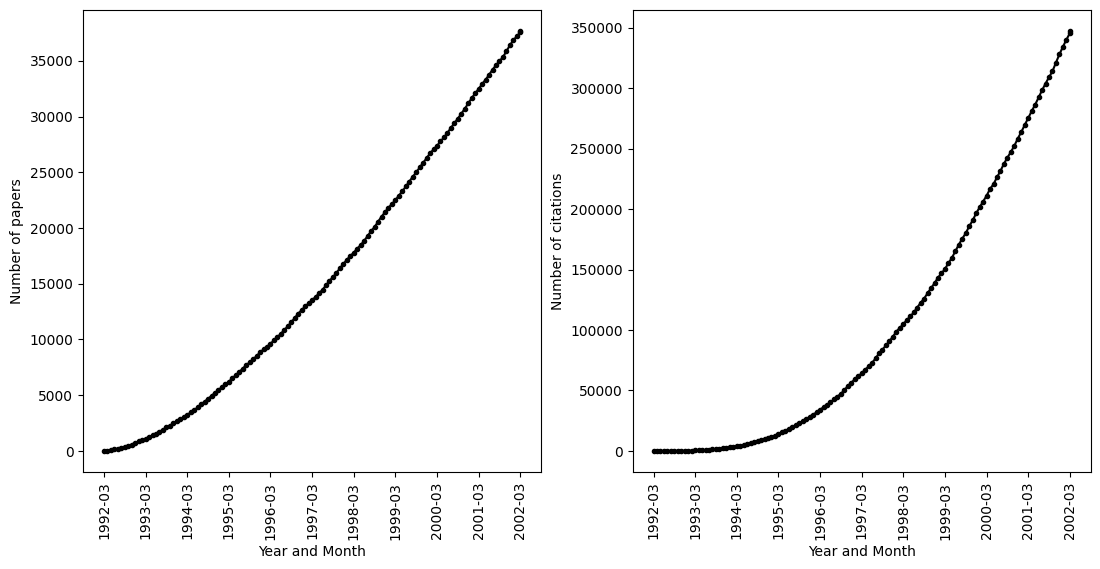

In [15]:
y_nodes = []
y_edges = []

for i, G in  enumerate(G_array):
    # print(f"num nodes = {G.number_of_nodes()}")
    y_nodes.append(G.number_of_nodes())
    y_edges.append(G.number_of_edges())

print(len(x_time))
print(len(y_nodes))

every_12th_time = x_time[::12] # used to get a clear labelling for the x-axis, otherwise the dates overlap
plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.plot(x_time, y_nodes, linestyle="-", marker=".", label="number of papers", color="black")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xlabel("Year and Month")
plt.ylabel("Number of papers")

plt.subplot(122)
plt.plot(x_time, y_edges, marker=".", label="number of citations", color="black")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xlabel("Year and Month")
plt.ylabel("Number of citations")
plt.show()

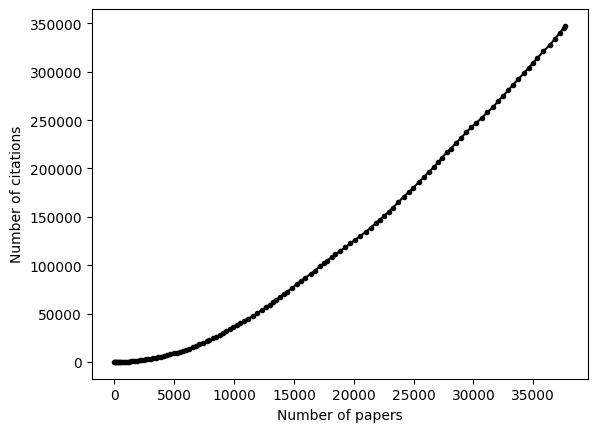

In [8]:
y_arr = []
for i, G in enumerate(G_array):
    y_arr.append(y_edges[i]/float(y_nodes[i]))

plt.plot(y_nodes, y_edges, marker=".", color="black")
plt.xlabel("Number of papers")
plt.ylabel("Number of citations")
plt.show()

### Property 2 - Plotting the Indegrees and the Outdegrees in the graphs
The plots show the pareto-like fat-tailed distribution. 
In every row, 
1. The first plot shows how a small number of papers are cited a very high number of times, while most of the papers barely get cited.
2. The second plot shows how a small number of papers cited a lot of other papers, while most of the papers did not site many papers.

Some examples of Pareto Distribution are displayed below:

<img src="./images/pareto_distribution.png" alt="Graph Showing Pareto Distribution" width="300px" height="300px">
<img src="./images/pareto_distribution2.png" alt="Graph Showing Pareto Distribution" width="300px" height="300px">

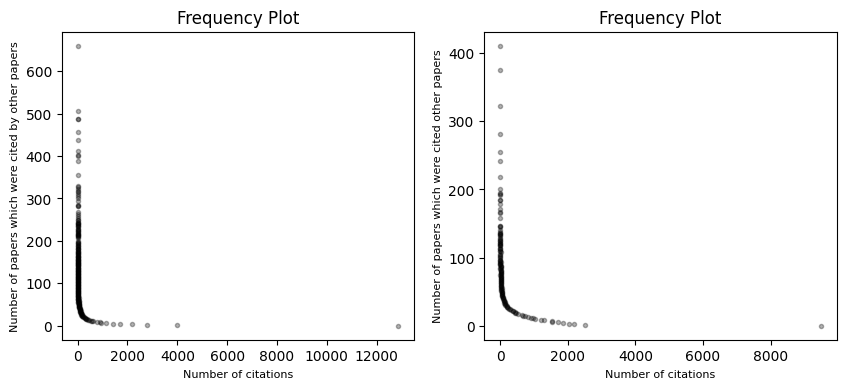

In [9]:
def plot_graph_degrees(G):
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    in_degrees = dict(sorted(in_degrees.items(), key=lambda item: -item[1]))
    out_degrees = dict(sorted(out_degrees.items(), key = lambda item: -item[1]))

    def plot_function(arr, xlabel, ylabel):
        d = {}
        for e in arr:
            if e not in d:
                d[e]=1
            else:
                d[e]+=1
        x = np.array(list(d.values()))
        y = np.array(list(d.keys()))

        # messing around
        # index_of_max = np.argmax(x)
        # x = np.delete(x, index_of_max)
        # y = np.delete(y, index_of_max)
        ####
        
        plt.scatter(x=x,y=y, marker=".", alpha=0.3, color="black")
        xlab = plt.xlabel(xlabel=xlabel)
        xlab.set_fontsize(8)
        ylab = plt.ylabel(ylabel=ylabel)
        ylab.set_fontsize(8)
        plt.title("Frequency Plot")


    in_degrees_values = np.array(list(in_degrees.values()))
    out_degrees_values = np.array(list(out_degrees.values()))

    plt.figure(figsize=(10, 4)) 
    plt.subplot(1, 2, 1) 
    plot_function(in_degrees_values, xlabel="Number of citations", ylabel="Number of papers which were cited by other papers")
    plt.subplot(1, 2, 2) 
    plot_function(out_degrees_values, xlabel="Number of citations", ylabel="Number of papers which were cited other papers")
    plt.show()


plot_graph_degrees(G)

### Property 3 - Density of the Graph

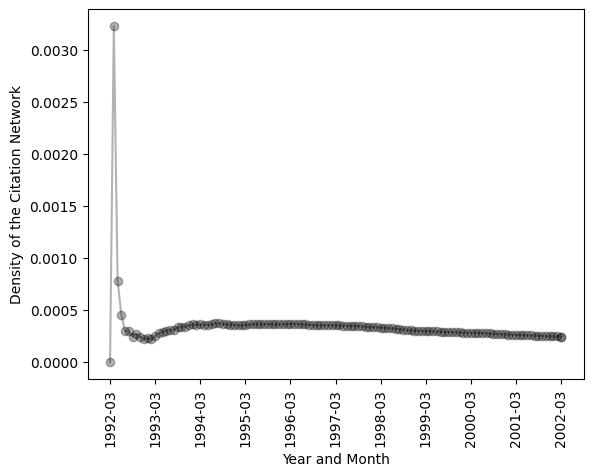

In [34]:
density_array = []
for digraph in G_array:
    density = nx.density(digraph)
    density_array.append(density)

plt.plot(x_time, density_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Density of the Citation Network")
plt.show()

### Property 4 - Average Clustering Coefficient

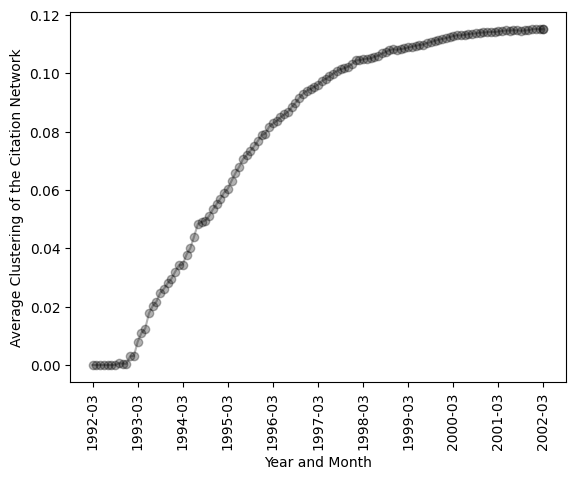

In [35]:
# TAKES 2 MINUTES TO RUN
# TIME COMPLEXITY = O(V*E)
average_clustering_array = []
for i, digraph in enumerate(G_array):
    average_clustering = nx.average_clustering(digraph)
    average_clustering_array.append(average_clustering)
    # print(f"{i}th graph has average clustering of: {average_clustering}")

plt.plot(x_time, average_clustering_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Average Clustering of the Citation Network")
plt.show()

### Property 5 - Identifying Citation Bursts

In [51]:
# Assuming G_array is a list of directed graphs
# G_array[i] represents the graph at time i

def identify_citation_bursts(G_array):
    bursts = []

    for i in range(1, len(G_array)):
        print(f"i = {i}")
        G_current = G_array[i]
        G_previous = G_array[i - 1]

        # Extracting citation data from the graphs
        edges_current = set(G_current.edges())
        edges_previous = set(G_previous.edges())

        # Find newly added citations
        new_citations = edges_current - edges_previous

        # Count new citations per paper
        citation_counts = pd.Series([target for _, target in new_citations]).value_counts()

        # Define a threshold for bursts
        threshold = 10  # Example threshold: 5 new citations

        # Identify papers with citation bursts
        papers_with_bursts = citation_counts[citation_counts > threshold].index.tolist()

        # Add information about the time period to the results
        bursts.extend([(paper, i) for paper in papers_with_bursts])

    return bursts

bursts_array = identify_citation_bursts(G_array)

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121


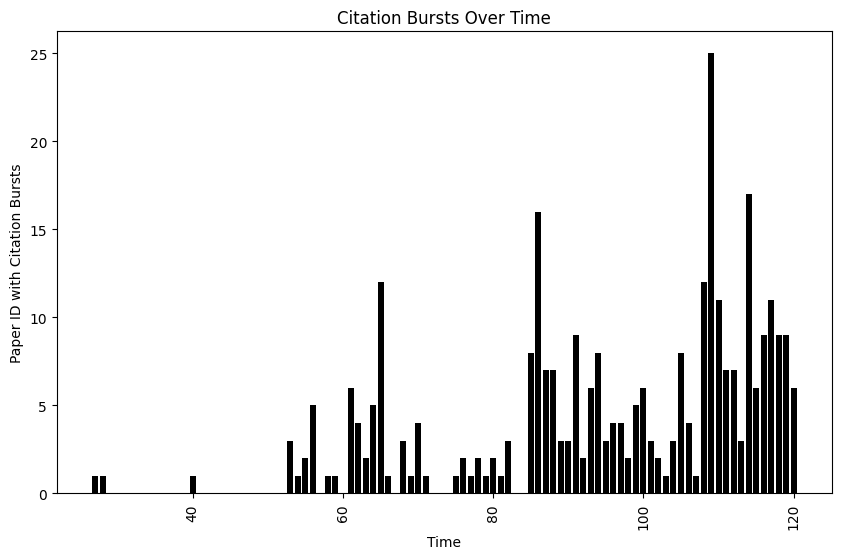

In [52]:
len(bursts_array)
# Extract information for plotting
papers, years = zip(*bursts_array)

# Plotting
plt.figure(figsize=(10, 6))
# plt.bar(times, papers, alpha=0.3) # plots node value vs time
plt.bar(sorted(set(years)), [years.count(year) for year in sorted(set(years))], color='black')
plt.xlabel('Time')
plt.ylabel('Paper ID with Citation Bursts')
plt.title('Citation Bursts Over Time')
plt.xticks(rotation=90)

# plt.xticks(range(1, max(times) + 1))
plt.show()


## Task 2

### Part 1 - Community Detection Algorithms
- Need to implement 2 algorithms

The following algorithms can be used:
1. Louvain (implemented for undirected graphs) (not an ml method)
2. deepwalk (random walk)   
3. node2vec  (bfs + dfs)
4. gcn (better suited for nodes with uniform degrees)
5. graphSAGE (better suited for nodes with non-uniform degrees) (has a random walk based approach as well)


#### Method 1 - Louvain Method

In [8]:
louvain_coms = algorithms.louvain(G.to_undirected(),weight="weight" ,resolution=1, randomize=False)
communities = louvain_coms.communities
print(type(communities[0]))
len(communities)

7200

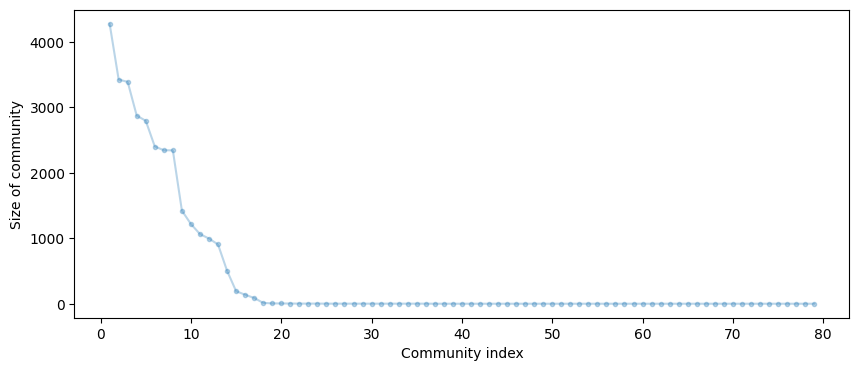

In [10]:
# for i, community in enumerate(communities):
#     print(f"{i+1}th community with size -> {len(community)}")

def plot_community_sizes(communities):
    x = []
    y = []
    for i, community in enumerate(communities):
        if len(community) > 1: # only plot communities with 2 or members
            y.append(len(community))
            x.append(i+1)
    
    plt.figure(figsize=(10, 4))
    plt.plot(x, y, marker=".", alpha=0.3)
    plt.xlabel("Community index")
    plt.ylabel("Size of community")
    plt.show()

plot_community_sizes(communities)


#### Method 2 - DeepWalk

In [16]:
def random_walk(start, length):
    walk = [str(start)]

    for i in range(length):
        neighbours = [node for node in G.neighbors(start)]
        if not neighbours:
            break
        next_node = np.random.choice(neighbours, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

walks = []
for node in G.nodes:
    # 80 random walks of length 10 for every node
    for _ in range(80):
        walks.append(random_walk(node, 10))


In [27]:
model = Word2Vec(walks,
                 hs=1,
                 sg=1,
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f"shape of embedding matrix: {model.wv.vectors.shape}")

# Retrieve node embeddings
node_embeddings = {str(node): model.wv[str(node)] for node in G.nodes}


# model.build_vocab(walks)

# model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

shape of embedding matrix: (37686, 100)


In [32]:
print(len(node_embeddings))
print(type(node_embeddings))

# Extract node features for clustering
X = np.array(list(node_embeddings.values()))

# Choose the number of clusters (you can adjust this based on your data)
num_clusters = 50

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(X)

# Assign cluster labels to nodes
cluster_labels = kmeans.labels_

# Create a dictionary mapping nodes to their cluster labels
node_cluster_mapping = dict(zip(G.nodes, cluster_labels))

# # Print the cluster assignments for each node
# for node, cluster_label in node_cluster_mapping.items():
#     print(f"Node {node} belongs to Cluster {cluster_label}")

37686
<class 'dict'>


In [36]:
# THIS WILL TAKE FOREVER
# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=10, random_state=42)
node_embeddings_2d = tsne.fit_transform(X)

# Plot the node embeddings
plt.figure(figsize=(10, 8))
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], alpha=0.7)

# Annotate points with node labels (optional)
for i, node in enumerate(G.nodes):
    plt.annotate(node, (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]))

plt.title('t-SNE Visualization of Node Embeddings')
plt.show()

#### Method 3 - Node2Vec

In [40]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=1)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# # Save the model if needed
# model.save("node2vec_model.model")

# Retrieve node embeddings
node_embeddings = {str(node): model.wv[str(node)] for node in G.nodes}

In [ ]:

X = np.array(list(node_embeddings.values()))
num_clusters = 5

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Assign cluster labels to nodes
cluster_labels = kmeans.labels_

# Create a dictionary mapping nodes to their cluster labels
node_cluster_mapping = dict(zip(G.nodes, cluster_labels))

# Print the cluster assignments for each node
for node, cluster_label in node_cluster_mapping.items():
    print(f"Node {node} belongs to Cluster {cluster_label}")

#### Method 4 - Graph Convolutional Network

#### Method 5 - GraphSAGE

### Part 2 - Analyzing the Communities

### Part 3 - Temporal Community Detection

## Task 3

### Link Prediction Algorithms
The following algorithms have been used for link prediction:  
- Node2Vec
- GraphSAGE

We have to implement one GNN method. Either GCN or GraphSAGE can be implemented.

However, if you have a graph with unevenly distributed node degrees and significant variability, GraphSAGE might be a more suitable choice for link prediction. It inherently samples neighborhoods during training, allowing it to handle nodes with different degrees more effectively.

### Comparing the Predictions